In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import gc
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 2390

In [2]:
import pymysql
import pandas as pd
import getpass
import re

conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd=getpass.getpass("Enter MySQL passwd for jovyan"),db='mimic2')
cursor = conn.cursor()

Enter MySQL passwd for jovyan········


In [3]:
mimic = pd.read_sql("""select text from noteevents""",conn)
mimic.shape

(171927, 1)

In [7]:
abi = pd.read_sql("""select c.subject_id, code, text 
                    from icd9 c, noteevents n
                    where c.subject_id = n.subject_id and code like '443%' 
                    and text like '%ankle%index%';""",conn)
abi = abi.assign(abi ='0')
pad = pd.read_sql("""select c.subject_id, code, text 
                    from icd9 c, noteevents n
                    where c.subject_id = n.subject_id and code like '443%' 
                    and text like '%peripheral vascular%';""",conn)
pad = pad.assign(pad='0')
pad.head()

,subject_id,code,text,pad
0,21,443.9,\n \n \n \nAdmission Date: [**3138-10-29**] ...,0
1,21,443.9,\n\n\n DATE: [**3139-3-21**] 9:23 AM\n ...,0
2,21,443.9,\n\n\n DATE: [**3139-3-21**] 9:23 AM\n ...,0
3,792,443.9,\n\nAdmission Date: [**2883-5-27**] Dis...,0
4,781,443.9,\n \n \n \nAdmission Date: [**2554-7-2**] ...,0


In [5]:


for message_no, message in enumerate(pad['text'][:10]):
    print(message_no, message)
    print('\n')



0 
 
 
 
Admission Date:  [**3138-10-29**]              Discharge Date:   [**3138-11-11**]
 
Date of Birth:  [**3051-5-22**]             Sex:   M
 
Service: MEDICINE
 
Allergies: 
Patient recorded as having No Known Allergies to Drugs
 
Attending:[**First Name3 (LF) 1919**] 
Chief Complaint:
chest pain, dyspnea
 
Major Surgical or Invasive Procedure:
cardiac catheterization with placement of three stents and IABP. 
 Swan catheter placement.

 
History of Present Illness:
HISTORY OF PRESENT ILLNESS: 87 yo M with chronic kidney disease 
s/p AV Graft placement [**9-19**], stroke, hypertension, diabetes, and 
peripheral vascular disease presents with chest pain and 
shortness of breath. He reports that his chest pain began 
approximately one week ago. During the week it has gotten worse. 
It is substernal, radiating to left shoulder, especially with 
inspiration. It is associated with shortness of breath. He came 
to the hospital today because the pain was much worse, [**10-24**]. In 
addi

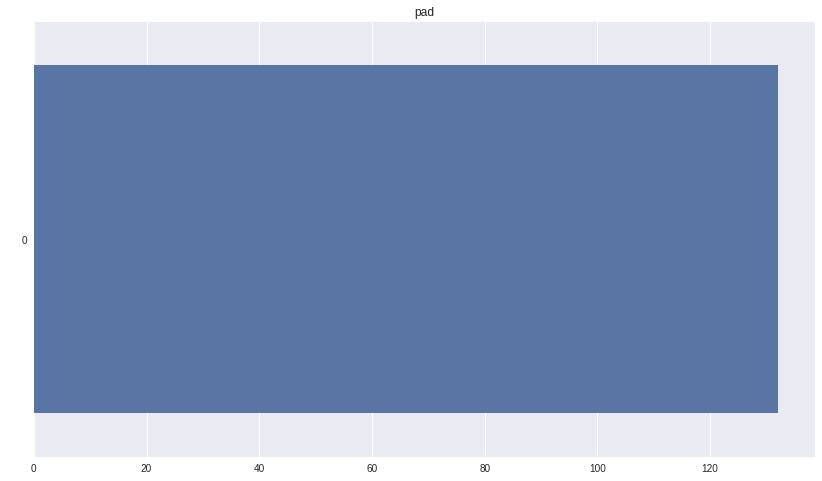

In [9]:


cols= ['pad']

plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
for i, cn in enumerate(cols):
    ax = plt.subplot(gs[i])
    sns.countplot(y = cn , data = pad)
    ax.set_xlabel('')
    ax.set_title(str(cn))
    ax.set_ylabel(' ')



In [10]:
abi1 = pad[['text','pad']]
#Messtype1['length'] = Messtype1['comment_text'].apply(len)
abi1['length'] = abi1['text'].str.split().apply(len)
abi1.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,pad,length
0,\n \n \n \nAdmission Date: [**3138-10-29**] ...,0,2116
1,\n\n\n DATE: [**3139-3-21**] 9:23 AM\n ...,0,200
2,\n\n\n DATE: [**3139-3-21**] 9:23 AM\n ...,0,200
3,\n\nAdmission Date: [**2883-5-27**] Dis...,0,1455
4,\n \n \n \nAdmission Date: [**2554-7-2**] ...,0,1668


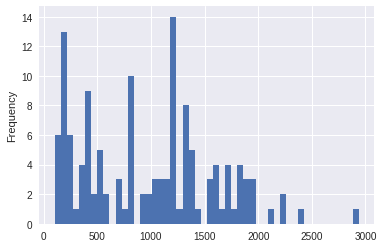

In [11]:


abi1['length'].plot(bins=50, kind='hist');



In [12]:


abi1.length.describe()



count     132.000000
mean      972.727273
std       621.195573
min       102.000000
25%       406.000000
50%      1004.500000
75%      1355.250000
max      2940.000000
Name: length, dtype: float64

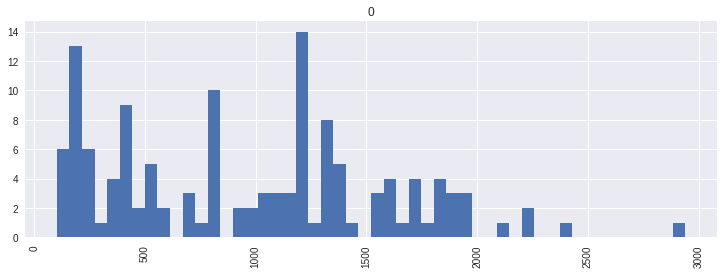

In [13]:

abi1.hist(column='length', by='pad', bins=50,figsize=(12,4));



In [14]:


def text_process(mess):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]



In [15]:


abi1['text'].head(5).apply(text_process)



0    [Admission, Date, 31381029, Discharge, Date, 3...
1    [DATE, 3139321, 923, MR, ANKLE, WWO, CONTRAST,...
2    [DATE, 3139321, 923, MR, ANKLE, WWO, CONTRAST,...
3    [Admission, Date, 2883527, Discharge, Date, 28...
4    [Admission, Date, 255472, Discharge, Date, 255...
Name: text, dtype: object

In [16]:
abi1.head()

,text,pad,length
0,\n \n \n \nAdmission Date: [**3138-10-29**] ...,0,2116
1,\n\n\n DATE: [**3139-3-21**] 9:23 AM\n ...,0,200
2,\n\n\n DATE: [**3139-3-21**] 9:23 AM\n ...,0,200
3,\n\nAdmission Date: [**2883-5-27**] Dis...,0,1455
4,\n \n \n \nAdmission Date: [**2554-7-2**] ...,0,1668


In [18]:


from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(abi1['text'], abi1['pad'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))



105 27 132


In [19]:


pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])



In [20]:


pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)



/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


In [21]:


print(classification_report(predictions,label_test))



             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00        27

